In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/assets/tokenizer/vocabulary.spm
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/assets/tokenizer/vocabulary.spm
/kaggle/input/automated-essay-scoring-2.0/ot

In [2]:
import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

2024-06-23 14:43:20.361978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 14:43:20.362079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 14:43:20.491920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install /kaggle/input/required-packages/Pyphen-0.9.3-py2.py3-none-any.whl >> none
!pip install /kaggle/input/required-packages/pyspellchecker-0.8.1-py3-none-any.whl >> none
!pip install /kaggle/input/required-packages/textstat-0.7.3-py3-none-any.whl >> none


In [4]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
import polars as pl
import spacy
from spellchecker import SpellChecker

from collections import OrderedDict, Counter, defaultdict
import re

In [6]:
import os
import re
import numpy as np 
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from tqdm import tqdm
import json, string
from typing import List

import spacy
from spellchecker import SpellChecker

from collections import OrderedDict, Counter, defaultdict

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import log_evaluation, early_stopping



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import mean_squared_error, cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [7]:
import textstat
from textblob import TextBlob
import joblib

In [8]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [58]:
df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')

## Distribution of score

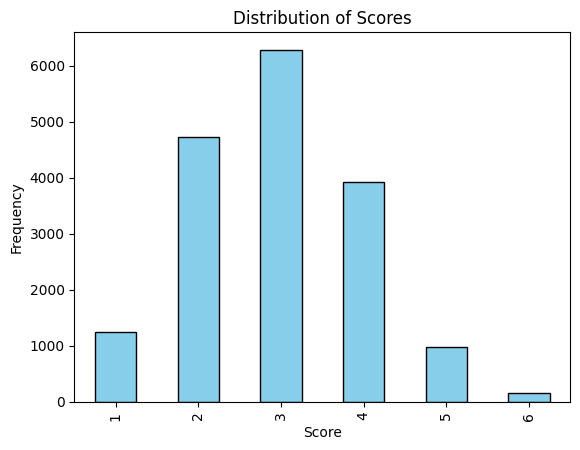

In [12]:
score_distribution = df['score'].value_counts().sort_index()

# Plot the distribution using a bar chart
score_distribution.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [13]:
# This is the list for stop words
stopwords_list = [
    "a", "about", "above", "according", "across", "actually", "adj", "after", "afterwards", "again",
    "all", "almost", "along", "already", "also", "although", "always", "among", "amongst", "an",
    "am", "and", "another", "any", "anyhow", "anyone", "anything", "anywhere", "are", "aren",
    "aren't", "around", "as", "at", "be", "became", "because", "become", "becomes", "been",
    "beforehand", "begin", "being", "below", "beside", "besides", "between", "both", "but", "by",
    "can", "cannot", "can't", "caption", "co", "come", "could", "couldn", "couldn't", "did", "didn",
    "didn't", "do", "does", "doesn", "doesn't", "don", "don't", "down", "during", "each", "early",
    "eg", "either", "else", "elsewhere", "end", "ending", "enough", "etc", "even", "ever", "every",
    "everywhere", "except", "few", "for", "found", "from", "further", "had", "has", "hasn", "hasn't",
    "have", "haven", "haven't", "he", "hence", "her", "here", "hereafter", "hereby", "herein",
    "hereupon", "hers", "him", "his", "how", "however", "ie", "i.e.", "if", "in", "inc", "inc.",
    "indeed", "instead", "into", "is", "isn", "isn't", "it", "its", "itself", "last", "late",
    "later", "less", "let", "like", "likely", "ll", "ltd", "made", "make", "makes", "many", "may",
    "maybe", "me", "meantime", "meanwhile", "might", "miss", "more", "most", "mostly", "mr", "mrs",
    "much", "must", "my", "myself", "namely", "near", "neither", "never", "nevertheless", "new",
    "next", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "not", "now", "NULL",
    "of", "off", "often", "on", "once", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "per", "perhaps", "rather", "re", "said", "same",
    "say", "seem", "seemed", "seeming", "seems", "several", "she", "should", "shouldn", "shouldn't",
    "since", "so", "some", "still", "stop", "such", "taking", "ten", "than", "that", "the", "their",
    "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore",
    "therein", "thereupon", "these", "they", "this", "those", "though", "thousand", "through",
    "throughout", "thru", "thus", "to", "together", "too", "toward", "towards", "under", "unless",
    "unlike", "unlikely", "until", "up", "upon", "us", "use", "used", "using", "ve", "very", "via",
    "was", "wasn", "we", "well", "were", "weren", "weren't", "what", "whatever", "when", "whence",
    "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever",
    "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whomever", "whose",
    "why", "will", "with", "within", "without", "won", "would", "wouldn", "wouldn't", "yes", "yet",
    "you", "your", "yours", "yourself", "yourselves"
]

final_stopwords_list = list(set(stopwords.words('english')) | set(stopwords_list))
print(len(final_stopwords_list))

337


In [14]:
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would",  ## --> he had or he would
    "he'd've": "he would have","he'll": "he will", "he'll've": "he will have", "he's": "he is", 
    "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is",
    "I'd": "I would",   ## --> I had or I would
    "I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","isn't": "is not",
    "it'd": "it had",   ## --> It had or It would
    "it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is",
    "let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have",
    "must've": "must have","mustn't": "must not","mustn't've": "must not have",
    "needn't": "need not","needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
    "she'd": "she would",   ## --> It had or It would
    "she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
    "should've": "should have","shouldn't": "should not","shouldn't've": "should not have",
    "so've": "so have","so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have","that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have","there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
    "to've": "to have","wasn't": "was not","weren't": "were not",
    "we'd": "we had",
    "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
    "what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have",
    "when's": "when is","when've": "when have",
    "where'd": "where did","where's": "where is","where've": "where have",
    "who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
    "will've": "will have","won't": "will not","won't've": "will not have",
    "would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
    "y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
    "y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have",
    "you're": "you are",  "you've": "you have"
}

contraction_pattern = re.compile('(%s)' % '|'.join(contractions .keys()))

def expand_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contraction_pattern.sub(replace, text)

In [15]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stop_words = set(final_stopwords_list)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def lemmatization(text):
    words = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if len(word) > 1]
    return ' '.join(lemmatized_words)

def preprocess_with_contractions_and_punctuation_removal(text):
    try:
        text = text.lower() # Convert words to lowercase
        text = re.sub(r'<.*?>', '', text)  # Remove HTML
        text = expand_contractions(text)
        text = remove_stopwords(text) # Remove stopwords
        text = re.sub("@\w+", '',text) # Delete strings starting with @
        text = text.replace(u'\xa0',' ') # Remove \xa0
        text = re.sub("'\d+", '',text) # Delete Numbers
        text = re.sub("\d+", '',text)
        text = re.sub(r'_+', ' ', text)
        text = re.sub("http\w+", '',text)     # Delete URL
        text = remove_punctuation(text) # Remove punctuation
        text = re.sub(r"\s+", " ", text) # Replace consecutive empty spaces with a single space character
        text = lemmatization(text) # Lemmatizing
        text = text.strip()
        return text
    except Exception as e:
        return ''


In [14]:
# text = "This is a test string with an 3?@@@..,,431111 \y21`trqz htrrrt invalid 89 <></>Unicode character: \uD800"
# preprocess_with_contractions_and_punctuation_removal(None)

In [16]:
import re
def preprocess_data(text):
    try:
        text = text.lower()
        text = re.sub(r'<.*?>', '', text) # Remove HTML
        text = re.sub("@\w+", '',text)     # Delete strings starting with @
        text = re.sub("\d+", '',text)
        text = re.sub("'\d+", '',text) # Delete Numbers
        text = re.sub("http\w+", '',text) # Delete URL
        text = text.replace(u'\xa0',' ') # Remove \xa0
        text = re.sub(r'_+', ' ', text)
        text = re.sub(r"\s+", " ", text)
        text = expand_contractions(text)
        # Replace consecutive commas and periods with one comma and period character
        text = re.sub(r"\.+", ".", text)
        text = re.sub(r"\,+", ",", text)
        text = re.sub(r"\s+", " ", text) # Replace consecutive empty spaces with a single space character
        text = text.strip()
        return text
    except Exception as e:
        return ''

### remove_duplicates:
used to remove duplicating sentence in an essay. There is a case in score 2 where there is a very long essay but the content is repeated setences. To process that kind of behavior, I'm removing duplicating sentences in essays.

### preprocessing_for_paragraphs: 
just normalize the text so that each \n\n is garantee to be the separator betweens paragraphs. It handles case where there are abundance of \n\n and if the text after the \n\n is undercase - which it will just treat as a another sentence in the paragrahph (not as a paragraph).

### extract_paragraphs:
Extract paragraph by using \n\n as delimitor.

In [17]:
def remove_duplicates(text):
    sentences = text.split('. ')
    
    # Use an OrderedDict to remove duplicates while preserving order
    unique_sentences = list(OrderedDict.fromkeys(sentences))
    
    # Join the unique sentences back into a single string
    result = '. '.join(unique_sentences)
    
    # Ensure the final sentence ends with a period if it originally did
    if text.endswith('.'):
        result += '.'
    
    return result

def extract_sentences(text):
    # Use a regular expression to split the text into sentences
    # This will handle periods, exclamation marks, and question marks as sentence terminators
    sentences = re.split(r'[.!?]+\s*', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def extract_words(text):
    words = re.findall(r"\w+(?:[-']\w+)*", text)
    return words

def preprocessing_for_paragraphs(text):
    # If before /n/n is not a mark, this is not the end of a paragraph    
    text = re.sub(r'(?<![\.\!\?])\n\n', ' ', text)

    #If after \n\n is an normal case, replace with space
    text = re.sub(r'\n\n([a-z])', ' ', text)
    
    return text.strip()

def extract_paragraphs(text):
    processed_text = preprocessing_for_paragraphs(text)
    paragraphs = processed_text.split('\n\n')
    
    return paragraphs

In [17]:
# columns = [(pl.col("full_text").apply(extract_paragraphs).alias("paragraph"))]
# df = pl.from_pandas(df).with_columns([pl.col("full_text").apply(remove_duplicates)])

# df = df.with_columns(columns)


* Paragraph_Preprocess: Calculate features paragraph_len, paragraph_sentence_cnt and paragraph_word_cnt.
* Paragraph_Eng: Calculate more advanced features that based on classification of paragraph_len - by bucket (the size probably change a lot but there are 2 ways to say this:
   - Accumalative: The paragraph is > 500, >600...
   - Bucked: The paragrah is between 0-200, 200-400...
   The code I'm using bucket classification.
* Features that it calculate:
  - Bucket (count accurance) of each paragraph to each bucket defined above.
  - Calculate features: max, mean, sum, min for each features created in Paragraph_Preprocess

In [18]:
# paragraph features
def paragraph_preprocess(temp_df):
    # Expand the paragraph list into several lines of data
    temp_df = temp_df.explode('paragraph')
    
    # Paragraph preprocessing
    temp_df = temp_df.with_columns(pl.col('paragraph').map_elements(preprocess_data))
    
    # Calculate the length of each paragraph
    temp_df = temp_df.with_columns(
        pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"),
        pl.col('paragraph').map_elements(lambda x: len(extract_sentences(x))).alias('paragraph_sentence_cnt'),
        pl.col('paragraph').map_elements(lambda x: len(extract_words(x))).alias('paragraph_word_cnt'),
        pl.col('paragraph').map_elements(lambda x: len(set(extract_words(x)))).alias('paragraph_unique_word_cnt')
    )
    return temp_df

In [19]:
length_ranges = [(1, 100), (101, 200), (201, 300), (301, 400), (401, 500), (501, 600), (601, 800)]
paragraph_fea = ['paragraph_len', 'paragraph_sentence_cnt', 'paragraph_word_cnt', 'paragraph_unique_word_cnt']

def paragraph_feature_engineering(train_df):
    count_aggs = [
        pl.col('paragraph').filter((pl.col('paragraph_len') >= start) & (pl.col('paragraph_len') <= end)).count().alias(f"paragraph_len_between_{start}_{end}_cnt")
        for start, end in length_ranges
    ]

    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_len_geq_{i}_cnt") for i in [100,150,200,300,350,400,500,600,700] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        ]

    df = train_df.group_by(['essay_id'], maintain_order=True).agg(count_aggs + aggs).sort("essay_id")
    df = df.to_pandas()
    return df

In [20]:
# train_preprocessed = paragraph_preprocess(df)
# train_features = paragraph_feature_engineering(train_preprocessed)

# # Obtain feature names
# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))

# print(f'Features Number: {len(feature_names)}')
# train_features.head(5)

# Sentence based features¶
**Now we will do some sentence processing. The steps is pretty similar to paragraph, which only a few differences:**

* Sentence_Preprocess: Calculate features sentence_len, sentence_word_cnt
* Sentence_Eng: Calculate bucketed ranges of sentence + max, min, mean of features created in Sentence_Preprocess.

In [20]:
def sentence_preprocess(temp_df):
    # Preprocess full_text and use periods to segment sentences in the text
    temp_df = temp_df.with_columns( pl.col('full_text').map_elements(preprocess_data).map_elements(extract_sentences).alias("sentences"))
    temp_df = temp_df.explode('sentences')
    
    temp_df = temp_df.with_columns(
        pl.col('sentences').map_elements(lambda x: len(x)).alias("sentence_len"),
        pl.col('sentences').map_elements(lambda x: len(extract_words(x))).alias("sentence_word_cnt"),
        pl.col('sentences').map_elements(lambda x: len(set(extract_words(x)))).alias("sentence_unique_word_cnt")
    )
    
    return temp_df

In [21]:
sentence_length_ranges = [(1, 50), (51, 100), (101, 150), (151, 300)]
sentence_fea = ['sentence_len','sentence_word_cnt', 'sentence_unique_word_cnt']

def sentence_feature_engineering(train_tmp):
    
    count_aggs = [
        pl.col('sentences').filter((pl.col('sentence_len') >= start) & (pl.col('sentence_len') <= end)).count().alias(f"sentence_len_between_{start}_{end}_cnt")
        for start, end in sentence_length_ranges
    ]
    
    aggs = [
        *[pl.col('sentences').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_len_geq_{i}_cnt") for i in [50,100,150,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
    ]

    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(count_aggs + aggs).sort("essay_id")
    df = df.to_pandas()
    
    return df

In [23]:
# train_preprocessed = sentence_preprocess(df)
# train_features = train_features.merge(sentence_feature_engineering(train_preprocessed), on='essay_id', how='left')

# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))
# print('Features Number: ',len(feature_names))
# train_features.head(5)

**Now we will do some sentence processing. The steps is pretty similar to paragraph and sentence, which only a few differences:**

* Word_Preprocess: Calculate features word_len (making sure word is not empty)
* Word_Eng: Calulate bucket length for word_len + max, mean, std, sum for features created in Word_Preprocess.

In [22]:
def word_preprocess(temp_df):
    # Preprocess full_text and use spaces to separate words from the text
    temp_df = temp_df.with_columns(pl.col('full_text').map_elements(preprocess_data).map_elements(extract_words).alias('word'))
    temp_df = temp_df.explode('word')
    
    # Calculate the length of each word
    temp_df = temp_df.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    
    # Delete data with a word length of 0
    temp_df = temp_df.filter(pl.col('word_len') != 0)
    
    return temp_df

In [23]:
word_length_ranges = [(1, 5), (6, 10), (11, 15)]

def word_feature_engineering(train_tmp):
    
    count_aggs = [
        pl.col('word').filter((pl.col('word_len') >= start) & (pl.col('word_len') <= end)).count().alias(f"word_len_between_{start}_{end}_cnt")
        for start, end in word_length_ranges
    ]
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_len_geq_{i+1}_cnt") for i in range(15) ], 

        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        ]

    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(count_aggs + aggs).sort("essay_id")
    
    df = df.to_pandas()
    
    return df

In [24]:
# train_preprocessed = word_preprocess(df)

# # Merge the newly generated feature data with the previously generated feature data
# train_features = train_features.merge(word_feature_engineering(train_preprocessed), on='essay_id', how='left')

# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))
# print('Features Number: ',len(feature_names))
# train_features.head(5)

In [25]:
#  train_features.columns

# Character TFIDF features¶

In [26]:
def tokenizer_function(x):
    return x

def preprocessor_function(x):
    return x

In [29]:
# character_tfidf_vectorizer = TfidfVectorizer(
#             tokenizer = tokenizer_function,
#             preprocessor = preprocessor_function,
#             token_pattern = None,
#             strip_accents = 'unicode',
#             analyzer = 'word',
#             ngram_range = (1,3),
#             min_df = 0.1,
#             max_df = 0.95,
#             sublinear_tf = True,
# )
# # Processed text
# processed_text = df["full_text"].apply(lambda x: preprocess_with_contractions_and_punctuation_removal(x))
# character_train_tfidf = character_tfidf_vectorizer.fit_transform([i for i in processed_text])
# joblib.dump(character_tfidf_vectorizer, 'character_tfidf_vectorizer.pkl')
# character_tfidf_feature_names = character_tfidf_vectorizer.get_feature_names_out()
# tfidf_features = pd.DataFrame(character_train_tfidf.toarray(), columns=[f"tfidf_{name}" for name in character_tfidf_feature_names ])
# tfidf_features['essay_id'] = train_features['essay_id']
# train_features = train_features.merge(tfidf_features, on='essay_id', how='left')

# print('Character tf-idf features:')
# print(character_tfidf_feature_names[0:100])

# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))
# print('Features Number: ',len(feature_names))
# train_features.head(5)

# Word TF-IDF

In [30]:
# # TfidfVectorizer parameter
# word_tfidf_vectorizer = TfidfVectorizer(
#     preprocessor = preprocessor_function,
#     strip_accents = 'unicode',
#     analyzer = 'word',
#     ngram_range = (1, 3),
#     min_df = 0.05,
#     max_df = 0.85,
#     sublinear_tf = True,
#     stop_words = final_stopwords_list,
# )

# # Fit all datasets into TfidfVectorizer
# train_tfidf = word_tfidf_vectorizer.fit_transform([i for i in processed_text])
# word_tfidf_feature_names = word_tfidf_vectorizer.get_feature_names_out()
# print('Word tf-idf features:')
# print(word_tfidf_feature_names[0:100])

# df_temp = pd.DataFrame(train_tfidf.toarray(), columns=[f"tfidf_{name}" for name in word_tfidf_feature_names])
# df_temp['essay_id'] = train_features['essay_id']
# train_features = train_features.merge(df_temp, on='essay_id', how='left')

# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))
# print('Features Number: ',len(feature_names))

# train_features.head(5)

In [31]:
# joblib.dump(word_tfidf_vectorizer, 'word_tfidf_vectorizer.pkl')

In [32]:
# joblib.dump(word_tfidf_feature_names, 'word_tfidf_feature_names.pkl')


In [33]:
# processed_text = df["full_text"].apply(lambda x: preprocess_data(x))

In [34]:
# processed_text

## Centroid Features
The logic for this feature is simple:

* We use TFIDF for the traind data and it looks like it works in the test data -> The essays in the test data must have similar words -> Might have the same topics as the train data.
* As we have encovered the essay topics in the dataset, we can use K-means to cluster them and calculate the distance between it and the centroid - effectively measure if the essays is close to its topic, and therefore - better.

In [35]:
# tfidf_w_columns = [ f'tfidf_{i}' for i in word_tfidf_feature_names]
# test_tfidf = train_features[tfidf_w_columns]
# test_tfidf[test_tfidf > 0].agg(['count', 'min', 'max', 'std', 'mean']).T.to_csv('tfidf_test.csv')
# # Create test copy of dataframe
# kmean_test = train_features[tfidf_w_columns]
# # Initialize KMeans with the number of clusters you want
# kmeans = KMeans(n_clusters=7, random_state=42)

# # Fit the model to the data
# kmeans.fit(kmean_test)


# # Predict the clusters for the data points
# labels = kmeans.labels_

# # Get the centroids
# centroids = kmeans.cluster_centers_

# joblib.dump(kmeans, 'kmeans_model.pkl')

# # Calculate the distance to the centroid
# distances = np.sqrt(((kmean_test - centroids[labels]) ** 2).sum(axis=1))

# cosine_distances_to_centroid = [
#     cosine_distances([kmean_test.iloc[i]], [centroids[label]])[0][0]
#     for i, label in enumerate(labels)
# ]

# # Add the distances to the DataFrame
# kmean_test['DistanceToCentroid'] = distances
# kmean_test['CosineDistanceToCentroid'] = cosine_distances_to_centroid

# train_features['DistanceToCentroid'] = kmean_test['DistanceToCentroid']
# train_features['CosineDistanceToCentroid'] = kmean_test['CosineDistanceToCentroid']

## CountVectorizer Features

In [36]:
# count_vectorizer = CountVectorizer(
#             strip_accents='unicode',
#             analyzer = 'word',
#             ngram_range=(2,3),
#             min_df=0.05, 
#             max_df=0.85,
# )

# train_count = count_vectorizer.fit_transform([i for i in processed_text])

# dense_matrix = train_count.toarray()
# word_count_feature_names = count_vectorizer.get_feature_names_out()
# print(word_count_feature_names[0:100])

# df = pd.DataFrame(dense_matrix,  columns=[f"count_{name}" for name in word_count_feature_names])
# df['essay_id'] = train_features['essay_id']
# train_features = train_features.merge(df, on='essay_id', how='left')

# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))
# print('Features Number: ',len(feature_names))
# train_features.head()

In [37]:
# joblib.dump(count_vectorizer, 'count_tfidf_vectorizer.pkl')

# Preprocessing

## Extra features:¶
Followings are some extra features.

* spelling: Calculate spelling mistakes in an essay
* count_sym: Calculate synnonym
* run: Calculate a bunch of features like unique_word_count, splling_err_num, full_stop_ratio, comma_ratio

In [38]:
nlp = spacy.load("en_core_web_sm")

In [27]:
class Preprocessor:
    def __init__(self) -> None:
        self.STOP_WORDS = set(final_stopwords_list)
        self.spellchecker = SpellChecker()

    def spelling(self, text):
        text_2 = re.sub(r'[^\w\s]', ' ', text)
        amount_miss = len(list(self.spellchecker.unknown(text_2.split())))
        return amount_miss
    
    def find_wrong_punctuation(self, text):
        punctuations = ['.', ',', ';', '?', '!', ':']
        lowercase_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        uppercase_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

        # find punctuation in the text
        wrong_punctuations = 0
        length = len(text)

        for i in range(length):
            if text[i] in punctuations and i < length - 1:
                if text[i + 1] in lowercase_list or text[i + 1] in uppercase_list:
                    wrong_punctuations += 1

        return wrong_punctuations
    
    def noun_verb_adj_adv_adp_others(self, text):
        doc = nlp(text)
        pos_counts = doc.count_by(spacy.attrs.POS)
        nouns = 0
        verbs = 0
        adj = 0
        adv = 0
        adp_conj = 0
        others = 0

        for pos_id, count in pos_counts.items():
            pos_tag = doc.vocab.strings[pos_id]
            if pos_tag in ['NOUN', 'PROPN', 'PRON']:
                nouns += count
            elif pos_tag in ['VERB', 'AUX']:
                verbs += count
            elif pos_tag == 'ADJ':
                adj += count
            elif pos_tag == 'ADV':
                adv += count
            elif pos_tag in ['ADP', 'CONJ']:
                adp_conj += count
            else:
                others += count

        return nouns, verbs, adj, adv, adp_conj, others
    
    def count_sym(self, text, sym):
        sym_count = 0
        for l in text:
            if l == sym:
                sym_count += 1
        return sym_count
    
    def lexical_diversity(self,text):
        # Tokenize the text into words
        words = nltk.word_tokenize(text)

        # Calculate the number of unique words (types) and total number of words (tokens)
        num_types = len(set(words))
        num_tokens = len(words)

        # Calculate the Type-Token Ratio (TTR)
        ttr = num_types / num_tokens

        return ttr
    
    def calculate_collocation_diversity(self,text):
        tokens = nltk.word_tokenize(text)
        finder = BigramCollocationFinder.from_words(tokens)
        return len(finder.score_ngrams(BigramAssocMeasures.mi_like)) / float(len(tokens))

    def calculate_collocation_strength(self,text):
        tokens = nltk.word_tokenize(text)
        finder = BigramCollocationFinder.from_words(tokens)
        collocations = finder.nbest(BigramAssocMeasures.mi_like, 10)  # Get top 10 collocations
        return sum(score for bigram, score in finder.score_ngrams(BigramAssocMeasures.mi_like)) / float(len(collocations))    

    def run(self, data: pd.DataFrame, mode:str) -> pd.DataFrame:
        
          # preprocessing the text
        data["processed_text"] = data["full_text"].apply(lambda x: preprocess_with_contractions_and_punctuation_removal(x))

            
        data[['nouns', 'verbs', 'adj', 'adv', 'adp_conj', 'others']] = data['processed_text'].apply(lambda x: pd.Series(self.noun_verb_adj_adv_adp_others(x)))
        
         # distinct word count
        data['distinct_word_count'] = data['processed_text'].apply(lambda x: len(set(word_tokenize(x))))
        
        # coleman
        data['coleman_liau'] = data['processed_text'].apply(lambda x: textstat.coleman_liau_index(x))
        
        # Text tokenization
        data["text_tokens"] = data["processed_text"].apply(lambda x: word_tokenize(x))
        
         # lexical diversity
        data['lexical_diversity'] = data['full_text'].apply(lambda x: self.lexical_diversity(x))
        
        # collocation diversity
        data['collocation_diversity'] = data['processed_text'].apply(lambda x: self.calculate_collocation_diversity(x))
                
        # collocation strength
        data['collocation_strength'] = data['processed_text'].apply(lambda x: self.calculate_collocation_strength(x))
        
        # essay length
        data["text_length"] = data["processed_text"].apply(lambda x: len(x))
        data["full_text_length"] = data["full_text"].apply(lambda x: len(x))
        
        # essay word count
        data["word_count"] = data["text_tokens"].apply(lambda x: len(x))
        
        # essay unique word count
        data["unique_word_count"] = data["text_tokens"].apply(lambda x: len(set(x)))
        
        # essay sentence count
        data["sentence_count"] = data["full_text"].apply(lambda x: len(extract_sentences(x)))
        
        # essay paragraph count
        data["paragraph_count"] = data["full_text"].apply(lambda x: len(extract_paragraphs(x)))
        
        # count misspelling
        data["splling_err_num"] = data["processed_text"].progress_apply(self.spelling)
        data["splling_err_ratio"] = data["splling_err_num"] / data["text_length"]
        
        # ratio fullstop / text_length 
        data["fullstop_ratio"] = data["full_text"].apply(lambda x: x.count(".")/len(x))
        
        # ratio comma / text_length
        data["comma_ratio"] = data["full_text"].apply(lambda x: x.count(",")/len(x))
        
        return data

In [40]:
# df.columns

In [41]:
# preprocessor = Preprocessor()
# tmp = preprocessor.run(df, mode="train")
# train_features = train_features.merge(tmp, on='essay_id', how='left')
# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_features.columns))

# print('Features Number: ',len(feature_names))
# train_features.head(5)

In [42]:
# train_features.to_csv('output.csv', index=False)

## Test Data

In [40]:
test_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv'

In [41]:
test = pd.read_csv(test_path)


In [45]:
# test = test.drop(columns=['score'])

In [42]:
test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [43]:
try: 
    columns = [(pl.col("full_text").apply(extract_paragraphs).alias("paragraph"))]
    test = pl.from_pandas(test).with_columns([pl.col("full_text").apply(remove_duplicates)])
    test = test.with_columns(columns)
except Exception as e:
    logging.error(f"Error during conversion to polars dataframe and removal of duplicates: {e}")


In [44]:
test

essay_id,full_text,paragraph
str,str,list[str]
"""000d118""","""Many people ha…","[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.""]"
"""000fe60""","""I am a scienti…","[""I am a scientist at NASA that is discussing the ""face"" on mars. I will be explaining how the ""face"" is a land form. By sharing my information about this isue i will tell you just that."", ""First off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this."", … ""To sum all this up the ""face"" on mars is a landform but others would like to beleive it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures..""]"
"""001ab80""","""People always …","[""People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and 

In [45]:
models_base_path = '/kaggle/input/automated-essay-scoring-2.0/other/lgbm/4'

In [46]:
try:
    # Paragraph
    logging.info("Starting paragraph preprocessing")
    tmp = paragraph_preprocess(test)
    test_features = paragraph_feature_engineering(tmp)
    logging.info("Paragraph preprocessing completed successfully")
except Exception as e:
    logging.error(f"Error during paragraph preprocessing: {e}")
print(test_features)
try:
    # Sentence
    logging.info("Starting sentence preprocessing")
    tmp = sentence_preprocess(test)
    test_features = test_features.merge(sentence_feature_engineering(tmp), on='essay_id', how='left')
    logging.info("Sentence preprocessing completed successfully")
except Exception as e:
    logging.error(f"Error during sentence preprocessing: {e}")

try:
    # Word
    logging.info("Starting word preprocessing")
    tmp = word_preprocess(test)
    test_features = test_features.merge(word_feature_engineering(tmp), on='essay_id', how='left')
    logging.info("Word preprocessing completed successfully")
except Exception as e:
    logging.error(f"Error during word preprocessing: {e}")

try:
    # Character Tfidf
    logging.info("Starting character TF-IDF vectorization")
    processed_text = test.to_pandas()["full_text"].progress_apply(lambda x: preprocess_with_contractions_and_punctuation_removal(x))

    character_tfidf_vectorizer = joblib.load(f"{models_base_path}/character_tfidf_vectorizer.pkl")
    test_tfidf = character_tfidf_vectorizer.transform([i for i in processed_text])
    feature_names = character_tfidf_vectorizer.get_feature_names_out()
    df = pd.DataFrame(test_tfidf.toarray(), columns=[f'tfidf_{name}' for name in feature_names])
    df['essay_id'] = test_features['essay_id']
    test_features = test_features.merge(df, on='essay_id', how='left')
    logging.info("Character TF-IDF vectorization completed successfully")
except Exception as e:
    logging.error(f"Error during character TF-IDF vectorization: {e}")

try:
    # Word Tfidf
    logging.info("Starting word TF-IDF vectorization")
    word_tfidf_vectorizer = joblib.load(f"{models_base_path}/word_tfidf_vectorizer.pkl")
    test_tfidf = word_tfidf_vectorizer.transform([i for i in processed_text])
    feature_names = word_tfidf_vectorizer.get_feature_names_out()
    df = pd.DataFrame(test_tfidf.toarray(), columns=[f'tfidf_{name}' for name in feature_names])
    df['essay_id'] = test_features['essay_id']
    test_features = test_features.merge(df, on='essay_id', how='left')
    logging.info("Word TF-IDF vectorization completed successfully")
except Exception as e:
    logging.error(f"Error during word TF-IDF vectorization: {e}")

try:
    # KMeans
    logging.info("Starting KMeans clustering")
    word_tfidf_feature_names = joblib.load(f"{models_base_path}/word_tfidf_feature_names.pkl")
    tfidf_w_columns = [f'tfidf_{i}' for i in word_tfidf_feature_names]

    kmean_test = test_features[tfidf_w_columns]
    kmeans = joblib.load(f"{models_base_path}/kmeans_model.pkl")

    labels = kmeans.predict(kmean_test)
    centroids = kmeans.cluster_centers_
    logging.info(f"Number of centroids: {len(centroids)}")
    distances = np.sqrt(((kmean_test - centroids[labels]) ** 2).sum(axis=1))
    cosine_distances_to_centroid = [
        cosine_distances([kmean_test.iloc[i]], [centroids[label]])[0][0]
        for i, label in enumerate(labels)
    ]

    kmean_test['DistanceToCentroid'] = distances
    kmean_test['CosineDistanceToCentroid'] = cosine_distances_to_centroid

    test_features['DistanceToCentroid'] = kmean_test['DistanceToCentroid']
    test_features['CosineDistanceToCentroid'] = kmean_test['CosineDistanceToCentroid']
    logging.info("KMeans clustering completed successfully")
except Exception as e:
    logging.error(f"Error during KMeans clustering: {e}")

try:
    # Word vectorize with Count Vectorizer
    logging.info("Starting word vectorization with Count Vectorizer")
    count_vectorizer = joblib.load(f"{models_base_path}/count_tfidf_vectorizer.pkl")
    test_count = count_vectorizer.transform([i for i in processed_text])
    feature_names = count_vectorizer.get_feature_names_out()
    test_count_df = pd.DataFrame(test_count.toarray(), columns=[f'count_{name}' for name in feature_names])
    test_count_df['essay_id'] = test_features['essay_id']
    test_features = test_features.merge(test_count_df, on='essay_id', how='left')
    logging.info("Word vectorization with Count Vectorizer completed successfully")
except Exception as e:
    logging.error(f"Error during word vectorization with Count Vectorizer: {e}")

try:
    # Extra feature
    logging.info("Starting extra feature preprocessing")
    preprocessor = Preprocessor()
    tmp = preprocessor.run(test.to_pandas(), mode="train")
    test_features = test_features.merge(tmp, on='essay_id', how='left')
    logging.info("Extra feature preprocessing completed successfully")
except Exception as e:
    logging.error(f"Error during extra feature preprocessing: {e}")

try:
    # Features number
    feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_features.columns))
    logging.info(f'Features number: {len(feature_names)}')
    logging.info(f"First few rows of test_features: \n{test_features.head(3)}")
except Exception as e:
    logging.error(f"Error during feature extraction or final merging: {e}")

  essay_id  paragraph_len_between_1_100_cnt  \
0  000d118                                0   
1  000fe60                                0   
2  001ab80                                0   

   paragraph_len_between_101_200_cnt  paragraph_len_between_201_300_cnt  \
0                                  0                                  0   
1                                  1                                  1   
2                                  0                                  0   

   paragraph_len_between_301_400_cnt  paragraph_len_between_401_500_cnt  \
0                                  0                                  0   
1                                  2                                  1   
2                                  0                                  1   

   paragraph_len_between_501_600_cnt  paragraph_len_between_601_800_cnt  \
0                                  0                                  0   
1                                  0                       

100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


In [48]:
test_features

,essay_id,paragraph_len_between_1_100_cnt,paragraph_len_between_101_200_cnt,paragraph_len_between_201_300_cnt,paragraph_len_between_301_400_cnt,paragraph_len_between_401_500_cnt,paragraph_len_between_501_600_cnt,paragraph_len_between_601_800_cnt,paragraph_len_geq_100_cnt,paragraph_len_geq_150_cnt,...,count_student becoming,count_study venus,count_studying venus,count_time greater,count_united state,count_venus author,count_venus worthy,count_venus worthy pursuit,count_vote president,count_worthy pursuit
0,000d118,0,0,0,0,0,0,0,1,1,...,0,0,0,0,2,0,0,0,0,0
1,000fe60,0,1,1,2,1,0,0,5,5,...,0,0,0,0,0,0,0,0,0,0
2,001ab80,0,0,0,0,1,1,0,4,4,...,0,0,0,0,0,0,0,0,0,0


## Deberta Embedding

In [52]:
#from transformers import DebertaTokenizer, TFDebertaModel

In [31]:
class DebertaEmbedder:
    def __init__(self):
        print("Loading DeBERTa model...")
        
        self.tokenizer = keras_nlp.models.DebertaV3Preprocessor.from_preset(
                                        "/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2",
                                        sequence_length=512)
        self.model = keras_nlp.models.DebertaV3Backbone.from_preset(
                        "/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2",
                        load_weights=True
                    )
        print("Model loaded.")

    def embed(self, texts, batch_size=64):
        print("Embedding texts using DeBERTa...")
        embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
            batch_texts = texts[i:i + batch_size]
            inputs = self.tokenizer(batch_texts)
            outputs = self.model(inputs)
            batch_embeddings = tf.reduce_mean(outputs, axis=1).numpy()
            embeddings.append(batch_embeddings)
        embeddings = np.vstack(embeddings)
        print("DeBERTa embeddings computed.")
        return embeddings

In [28]:
processed_df = df['full_text'].apply(lambda x: preprocess_data(x))


In [32]:

embedder = DebertaEmbedder()
embeddings = embedder.embed(processed_df.tolist())


Loading DeBERTa model...
Model loaded.
Embedding texts using DeBERTa...


Processing Batches: 100%|██████████| 271/271 [10:21<00:00,  2.29s/it]

DeBERTa embeddings computed.


In [33]:
embeddings.shape

(17307, 768)

In [34]:
num_columns = len(embeddings[0])
column_names = [f'deb{i+1}' for i in range(num_columns)]

# Convert 2D list to DataFrame
embedding_df = pd.DataFrame(embeddings, columns=column_names)

In [35]:
embedding_df.to_csv('embedding_df.csv',index=False)

In [36]:
processed_train_df = pd.read_csv('/kaggle/input/processed-test-and-train/train_processed.csv')

In [37]:
processed_train_df

,essay_id,paragraph_len_between_1_100_cnt,paragraph_len_between_101_200_cnt,paragraph_len_between_201_300_cnt,paragraph_len_between_301_400_cnt,paragraph_len_between_401_500_cnt,paragraph_len_between_501_600_cnt,paragraph_len_between_601_800_cnt,paragraph_len_geq_100_cnt,paragraph_len_geq_150_cnt,...,text_length,full_text_length,word_count,unique_word_count,sentence_count,paragraph_count,splling_err_num,splling_err_ratio,fullstop_ratio,comma_ratio
0,000d118,0,0,0,0,0,0,0,1,1,...,1447,2677,220,144,13,1,23,0.015895,0.004856,0.005230
1,000fe60,0,1,1,2,1,0,0,5,5,...,709,1669,108,68,21,5,8,0.011283,0.011384,0.003595
2,001ab80,0,0,0,0,1,1,0,4,4,...,1491,3077,208,125,24,4,7,0.004695,0.007800,0.005200
3,001bdc0,0,0,0,2,0,0,0,4,4,...,1667,2701,217,140,21,4,8,0.004799,0.008515,0.007034
4,002ba53,1,0,0,1,0,2,1,4,4,...,1361,2208,172,89,16,5,9,0.006613,0.006793,0.005888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,0,1,1,0,1,0,0,3,2,...,488,856,69,54,9,3,12,0.024590,0.010514,0.001168
17303,ffddf1f,0,0,0,0,0,0,2,4,4,...,1962,3354,270,146,29,4,16,0.008155,0.008348,0.007156
17304,fff016d,0,0,0,2,1,0,0,3,3,...,440,1122,70,41,15,3,2,0.004545,0.013369,0.000000
17305,fffb49b,0,0,0,0,0,0,0,1,1,...,947,1427,123,87,11,1,9,0.009504,0.007708,0.008409


In [38]:
merged_train = pd.concat([processed_train_df,embedding_df ], axis=1)

In [39]:
merged_train

,essay_id,paragraph_len_between_1_100_cnt,paragraph_len_between_101_200_cnt,paragraph_len_between_201_300_cnt,paragraph_len_between_301_400_cnt,paragraph_len_between_401_500_cnt,paragraph_len_between_501_600_cnt,paragraph_len_between_601_800_cnt,paragraph_len_geq_100_cnt,paragraph_len_geq_150_cnt,...,deb759,deb760,deb761,deb762,deb763,deb764,deb765,deb766,deb767,deb768
0,000d118,0,0,0,0,0,0,0,1,1,...,-0.217344,0.018540,-0.282586,-0.157145,0.170728,-0.166559,0.246083,-0.220815,-0.047066,-0.220532
1,000fe60,0,1,1,2,1,0,0,5,5,...,-0.141937,0.087901,-0.330568,-0.236012,0.032010,-0.179224,0.215996,-0.108642,-0.070531,-0.016395
2,001ab80,0,0,0,0,1,1,0,4,4,...,-0.246763,0.169429,-0.384459,-0.209756,-0.003857,-0.085820,0.395393,0.002407,-0.097835,-0.175761
3,001bdc0,0,0,0,2,0,0,0,4,4,...,-0.435683,0.058801,-0.263443,-0.092462,0.217853,-0.120783,0.134740,-0.160418,0.060062,-0.052461
4,002ba53,1,0,0,1,0,2,1,4,4,...,-0.070586,-0.132991,-0.136065,-0.011969,-0.016728,-0.123621,-0.069454,-0.084828,-0.175720,0.137629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,0,1,1,0,1,0,0,3,2,...,-0.135346,0.042375,-0.135946,-0.157980,0.039343,-0.119564,0.152220,-0.071104,0.061617,-0.007613
17303,ffddf1f,0,0,0,0,0,0,2,4,4,...,-0.248739,0.159493,-0.400013,-0.271566,0.287773,-0.153337,0.381412,-0.098197,-0.054254,-0.201549
17304,fff016d,0,0,0,2,1,0,0,3,3,...,-0.150876,0.057917,-0.184834,-0.146885,0.003497,-0.169453,0.181223,-0.091543,0.017095,-0.050665
17305,fffb49b,0,0,0,0,0,0,0,1,1,...,-0.153368,-0.106410,-0.034392,-0.064250,0.007048,-0.139492,0.071544,-0.181751,-0.018598,0.145590


## Embedding for test data

In [50]:
processed__test_df = test['full_text'].apply(lambda x: preprocess_data(x))

In [51]:
processed__test_df

full_text
str
"""many people ha…"
"""i am a scienti…"
"""people always …"


In [66]:
processed__test_df

full_text
str
"""many people ha…"
"""i am a scienti…"
"""people always …"


In [52]:
embedding_df_test = None
try:
    print("Hello")
    logging.info(f"bedrta embedding start: ")
    embeddings_test = embedder.embed(processed__test_df.to_list())
    print(embeddings_test)
    num_columns_test = len(embeddings_test[0])
    column_names = [f'deb{i+1}' for i in range(num_columns_test)]

    # Convert 2D list to DataFrame
    embedding_df_test = pd.DataFrame(embeddings_test, columns=column_names)
except Exception as e:
    logging.error(f"Error during embedding deberta: {e}")

Hello
Embedding texts using DeBERTa...


Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

DeBERTa embeddings computed.
[[-0.12210955 -0.02981236  0.2710009  ... -0.22081536 -0.04706628
  -0.22053224]
 [-0.06428286 -0.04472257  0.23339188 ... -0.10864227 -0.07053053
  -0.01639501]
 [-0.05931892 -0.06240807  0.33283776 ...  0.00240716 -0.09783541
  -0.17576145]]


In [68]:
#embedding_df_test.to_csv('embedding_df_test.csv',index=False)

In [49]:
preprocessed_test_df = pd.read_csv('/kaggle/input/processed-test-and-train/test_preprocessed.csv')

In [54]:
embedding_df_test

,deb1,deb2,deb3,deb4,deb5,deb6,deb7,deb8,deb9,deb10,...,deb759,deb760,deb761,deb762,deb763,deb764,deb765,deb766,deb767,deb768
0,-0.122110,-0.029812,0.271001,-0.054723,-0.225351,-0.012073,0.229846,-0.057254,0.155538,-0.147127,...,-0.217344,0.018540,-0.282586,-0.157145,0.170728,-0.166559,0.246083,-0.220815,-0.047066,-0.220532
1,-0.064283,-0.044723,0.233392,0.015479,0.026259,0.024546,0.260620,-0.059868,0.080771,0.025266,...,-0.141937,0.087901,-0.330568,-0.236012,0.032010,-0.179224,0.215996,-0.108642,-0.070531,-0.016395
2,-0.059319,-0.062408,0.332838,0.007388,0.033437,-0.174701,0.256190,-0.033434,0.021591,0.009860,...,-0.246763,0.169429,-0.384459,-0.209756,-0.003857,-0.085820,0.395393,0.002407,-0.097835,-0.175761


In [55]:
merged_test = pd.concat([preprocessed_test_df,embedding_df_test ], axis=1)

In [56]:
merged_test

,essay_id,paragraph_len_between_1_100_cnt,paragraph_len_between_101_200_cnt,paragraph_len_between_201_300_cnt,paragraph_len_between_301_400_cnt,paragraph_len_between_401_500_cnt,paragraph_len_between_501_600_cnt,paragraph_len_between_601_800_cnt,paragraph_len_geq_100_cnt,paragraph_len_geq_150_cnt,...,deb759,deb760,deb761,deb762,deb763,deb764,deb765,deb766,deb767,deb768
0,000d118,0,0,0,0,0,0,0,1,1,...,-0.217344,0.018540,-0.282586,-0.157145,0.170728,-0.166559,0.246083,-0.220815,-0.047066,-0.220532
1,000fe60,0,1,1,2,1,0,0,5,5,...,-0.141937,0.087901,-0.330568,-0.236012,0.032010,-0.179224,0.215996,-0.108642,-0.070531,-0.016395
2,001ab80,0,0,0,0,1,1,0,4,4,...,-0.246763,0.169429,-0.384459,-0.209756,-0.003857,-0.085820,0.395393,0.002407,-0.097835,-0.175761


# Data Preparation

In [62]:
merged_train['score'] = df['score']

In [64]:
merged_train['score']

0        3
1        3
2        4
3        4
4        3
        ..
17302    2
17303    4
17304    2
17305    1
17306    2
Name: score, Length: 17307, dtype: int64

In [65]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Columns: 3108 entries, essay_id to deb768
dtypes: float32(768), float64(2208), int64(128), object(4)
memory usage: 359.7+ MB


In [66]:
set(merged_test.columns)-set(merged_train.columns)

{'paragraph'}

## Add k-fold details

In [67]:
n_splits = 5

seed = 42

In [68]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

for i, (_, val_index) in enumerate(skf.split(merged_train, merged_train["score"])):
    merged_train.loc[val_index, "fold"] = i
    
    
print(merged_train.shape)

(17307, 3109)


 ## Feature selection

In [69]:
target = "score"
train_drop_columns = ["essay_id", "fold", "full_text", "text_tokens", "processed_text"] + [target]
test_drop_columns = ["essay_id", "full_text", "paragraph", "text_tokens", "processed_text"]

In [70]:
def sanitize_feature_names(df):
    sanitized_columns = {col: re.sub(r'[^\w]', '_', col) for col in df.columns}
    df.rename(columns=sanitized_columns, inplace=True)
    return df

In [71]:
train_features = sanitize_feature_names(merged_train)
test_features = sanitize_feature_names(merged_test)

In [72]:
test_features.columns

Index(['essay_id', 'paragraph_len_between_1_100_cnt',
       'paragraph_len_between_101_200_cnt',
       'paragraph_len_between_201_300_cnt',
       'paragraph_len_between_301_400_cnt',
       'paragraph_len_between_401_500_cnt',
       'paragraph_len_between_501_600_cnt',
       'paragraph_len_between_601_800_cnt', 'paragraph_len_geq_100_cnt',
       'paragraph_len_geq_150_cnt',
       ...
       'deb759', 'deb760', 'deb761', 'deb762', 'deb763', 'deb764', 'deb765',
       'deb766', 'deb767', 'deb768'],
      dtype='object', length=3108)

# Training

### Loss  and evaluation methods

In [73]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = (y_true + a).round()
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    
    return 'QWK', qwk, True

def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2 * np.sum((preds-labels)**2)
    g = 1/2 * np.sum((preds-a)**2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg / g**2) * len(labels)
    hess = np.ones(len(labels))
    
    return grad, hess

def qwk_param_calc(y):
    a = y.mean()
    b = (y ** 2).mean() - a ** 2
    
    return np.round(a, 4), np.round(b, 4)

In [74]:
models = []

callbacks = [
    lgb.log_evaluation(period=25), 
    lgb.early_stopping(stopping_rounds=75, first_metric_only=True)
]

for fold in range(n_splits):

    model = lgb.LGBMRegressor(
                            objective = qwk_obj,
                            metrics = 'None',
                            learning_rate = 0.05,
                            max_depth = 5,
                            num_leaves = 10, 
                            colsample_bytree = 0.5,   
                            reg_alpha = 0.1,  
                            reg_lambda = 0.8,
                            n_estimators = 1024,
                            random_state = seed, 
                            extra_trees=True,
                            class_weight='balanced',
                            verbosity = - 1
                            )
    
    a, b = qwk_param_calc(train_features[train_features["fold"] != fold]["score"])
    
    # Take out the training and validation sets for 5 kfold segmentation separately
    X_train = train_features[train_features["fold"] != fold].drop(columns=train_drop_columns)
    y_train = train_features[train_features["fold"] != fold]["score"] - a

    X_eval = train_features[train_features["fold"] == fold].drop(columns=train_drop_columns)
    y_eval = train_features[train_features["fold"] == fold]["score"] - a

    print('\nFold_{} Training ================================\n'.format(fold+1))
    print(f"Fold {fold} a: {a}  ;;  b: {b}")
    
    # Training model
    lgb_model = model.fit(
                            X_train, y_train,
                            eval_names = ['train', 'valid'],
                            eval_set = [(X_train, y_train), (X_eval, y_eval)],
                            eval_metric = quadratic_weighted_kappa,
                            callbacks = callbacks
                        )
    
    models.append(model)


Fold_1 Training ================================

Fold 0 a: 2.9484  ;;  b: 1.0917
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.736315	valid's QWK: 0.736746
[50]	train's QWK: 0.777043	valid's QWK: 0.774114
[75]	train's QWK: 0.797906	valid's QWK: 0.791722
[100]	train's QWK: 0.808019	valid's QWK: 0.801108
[125]	train's QWK: 0.816351	valid's QWK: 0.806112
[150]	train's QWK: 0.822135	valid's QWK: 0.807764
[175]	train's QWK: 0.826339	valid's QWK: 0.811305
[200]	train's QWK: 0.830937	valid's QWK: 0.812295
[225]	train's QWK: 0.834565	valid's QWK: 0.813142
[250]	train's QWK: 0.838798	valid's QWK: 0.815255
[275]	train's QWK: 0.84175	valid's QWK: 0.814294
[300]	train's QWK: 0.844731	valid's QWK: 0.815679
[325]	train's QWK: 0.847611	valid's QWK: 0.815773
[350]	train's QWK: 0.8494	valid's QWK: 0.817453
[375]	train's QWK: 0.852045	valid's QWK: 0.819231
[400]	train's QWK: 0.85476	valid's QWK: 0.820198
[425]	t

### Validating model

In [75]:
preds, trues = [], []

for fold, model in enumerate(models):
    X_eval_cv = train_features[train_features["fold"] == fold].drop(columns=train_drop_columns)
    y_eval_cv = train_features[train_features["fold"] == fold]["score"]    

    pred = model.predict(X_eval_cv) + a
    
    pred[pred < 1] = 1
    pred[pred > 6] = 6
    
    trues.extend(y_eval_cv)
    preds.extend(np.round(pred, 0))
    
    v_score = cohen_kappa_score(trues, preds, weights="quadratic")
    
    print(f"Validation score {fold} : {v_score}")

v_score = cohen_kappa_score(trues, preds, weights="quadratic")
print(f"Validation score : {v_score}")

Validation score 0 : 0.8224515968847739
Validation score 1 : 0.8238858260010777
Validation score 2 : 0.8185175417009449
Validation score 3 : 0.8189839721056866
Validation score 4 : 0.8187383973458046
Validation score : 0.8187383973458046


### Analyize prediction

     trues  correct_rate  correct_count  count
12     1.0      0.482428            604   1252
1      2.0      0.723904           3419   4723
5      3.0      0.641720           4030   6280
0      4.0      0.642639           2523   3926
27     5.0      0.600000            582    970
100    6.0      0.403846             63    156


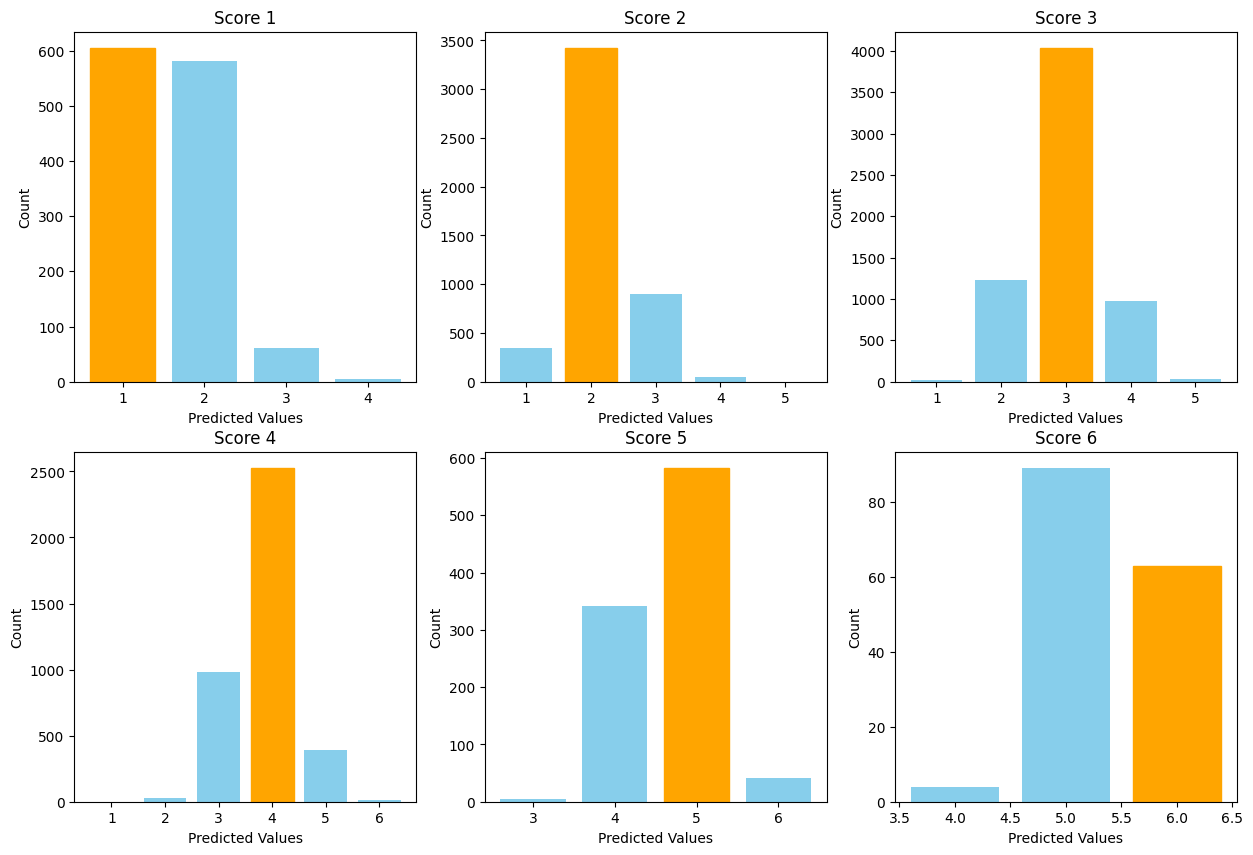

In [76]:
def analyze_preds(trues, preds):
    # Create dataframe
    model_prec = pd.DataFrame([trues, preds]).T
    model_prec.rename(columns = {0: 'trues', 1: 'preds'}, inplace=True)
    model_prec['correct'] = model_prec['trues'] == model_prec['preds']
    model_prec['count'] = model_prec.groupby('trues')['trues'].transform('count')
    model_prec['correct_count'] = model_prec.groupby('trues')['correct'].transform('sum')
    model_prec['correct_rate'] = model_prec['correct_count'] / model_prec['count']
    
    # Print binary correction rate
    print(model_prec[['trues', 'correct_rate', 'correct_count', 'count']].drop_duplicates().sort_values(by='trues'))
    
    # Plot predictions by score    
    def plot_model(ax, counts, true):
        bars = ax.bar(counts.index, counts.values, color='skyblue')

        # Find the index of the column with the specified label
        highlight_index = counts.index.get_loc(true)

        # Highlight the specified column
        bars[highlight_index].set_color('orange')

        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Count')
        ax.set_title("Score " + str(true))
    
    score_list = [1,2,3,4,5,6]
    test_pred_by_score = [model_prec[model_prec['trues'] ==  score]['preds'].value_counts() for score in score_list]

    # Create a figure and six subplots arranged in a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))    
    plot_model(axs[0, 0], test_pred_by_score[0], 1)
    plot_model(axs[0, 1], test_pred_by_score[1], 2)
    plot_model(axs[0, 2], test_pred_by_score[2], 3)
    plot_model(axs[1, 0], test_pred_by_score[3], 4)
    plot_model(axs[1, 1], test_pred_by_score[4], 5)
    plot_model(axs[1, 2], test_pred_by_score[5], 6)
    
analyze_preds(trues, preds)

### See how model workds

In [77]:
X_train_tmp = train_features.drop(columns=train_drop_columns)
y_train_tmp = train_features["score"]

def interact_tree(example_index, tree_index): 
    example = pd.DataFrame(X_train_tmp.iloc[example_index]).T
    score = y_train_tmp.iloc[example_index]
    
    print("Score: ", score)
    # Plot the first tree
    ax = lgb.plot_tree(models[1], tree_index=tree_index, figsize=(20, 8), show_info='data_percentage', example_case=example)
    plt.show()

Score:  3


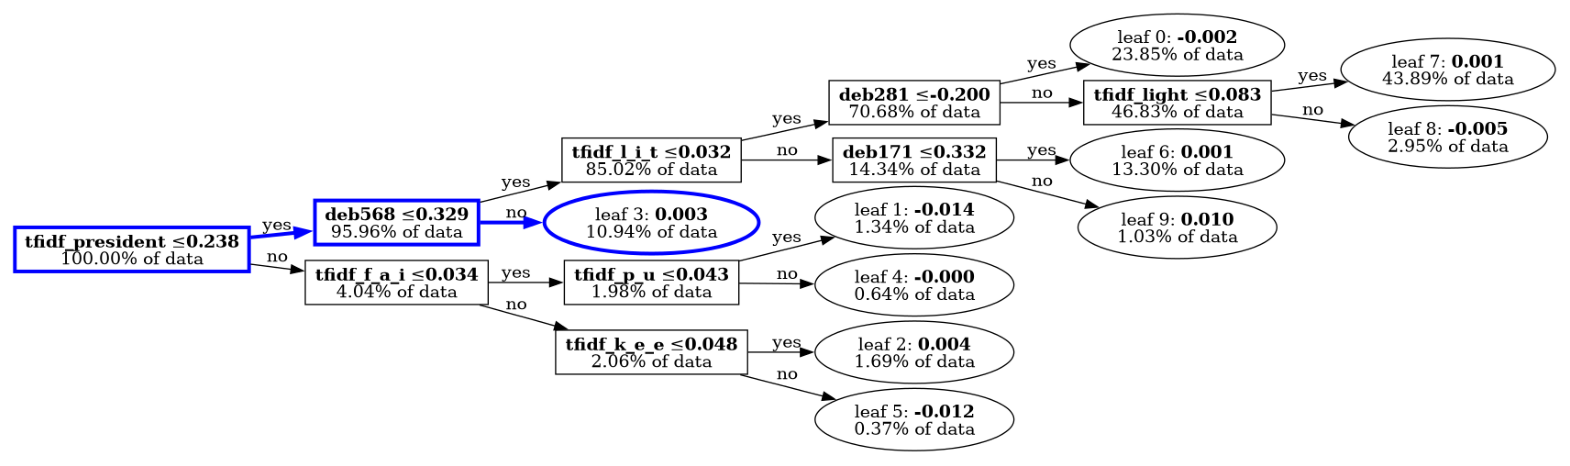

In [79]:
interact_tree(0,200)

In [80]:
top_features = ['splling_err_ratio', 'lexical_diversity', 'paragraph_count', 'word_count', 'DistanceToCentroid', 'word_len_sum']

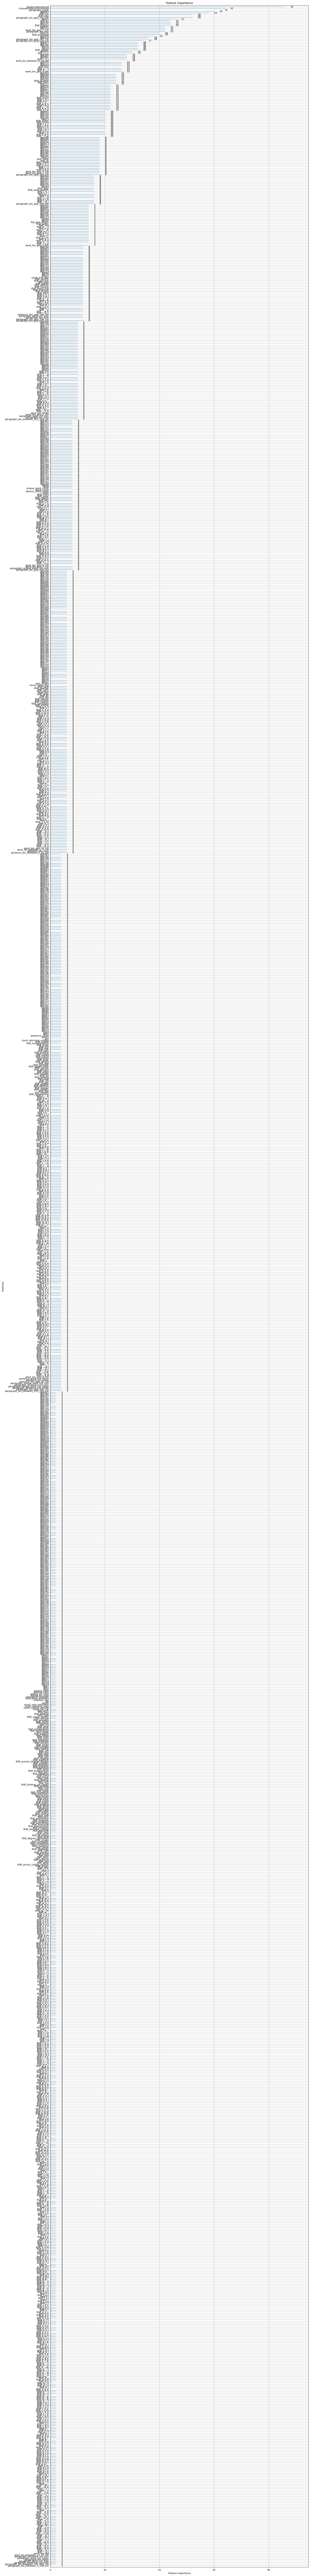

In [81]:
ax = lgb.plot_importance(models[1], figsize=(20, 200), importance_type="split")
plt.show()

In [82]:
import csv
feature_importance_df = pd.DataFrame()
feature_names = train_features.drop(columns=train_drop_columns).columns
feature_importance_df['Feature'] = feature_names

for i in range(0, 5):
    importance = models[i].feature_importances_
    feature_importance_df[f'Importance_{i}'] = importance

feature_importance_df.to_csv("feature_importance.csv")

In [91]:
# def show_feat_use(feat):
#     ax = lgb.plot_split_value_histogram(models[2], figsize=(20, 8), feature=feat)
#     plt.show()

In [92]:
# show_feat_use('tfidf_luke')

### How overfit model is 

In [83]:
def check_model_fit(model_id):
    ax = lgb.plot_metric(models[model_id])
    plt.show()

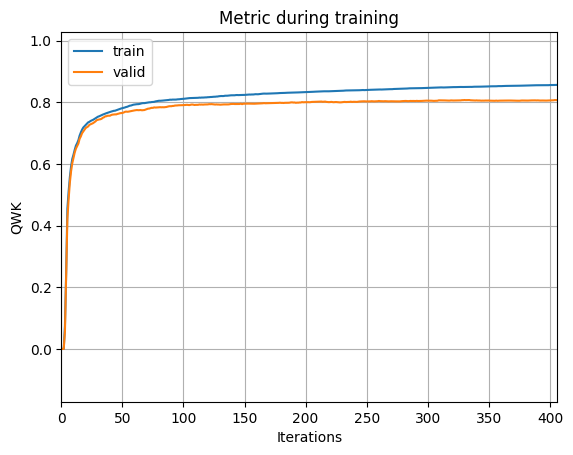

In [84]:
check_model_fit(2)

### Save Model

In [85]:
for i in range(len(models)):
    models[i].booster_.save_model(f'model_{i}.txt')

## Load Model

In [96]:
# models_path = [f"{models_base_path}/model_0.txt",f"{models_base_path}/model_1.txt",f"{models_base_path}/model_2.txt",f"{models_base_path}/model_3.txt",f"{models_base_path}/model_4.txt"]

In [97]:
# models = []
# try:
#     logging.info(f"Model declaration:")
#     for i in range(n_splits):
#         loaded_model  = lgb.Booster(model_file=models_path[i])
#         models.append(loaded_model)
# except Exception as e:
#     logging.error(f"Error during model declaration: {e}")    

In [86]:
models

[LGBMRegressor(class_weight='balanced', colsample_bytree=0.5, extra_trees=True,
               learning_rate=0.05, max_depth=5, metrics='None',
               n_estimators=1024, num_leaves=10,
               objective=<function qwk_obj at 0x7e4d31120ee0>, random_state=42,
               reg_alpha=0.1, reg_lambda=0.8, verbosity=-1),
 LGBMRegressor(class_weight='balanced', colsample_bytree=0.5, extra_trees=True,
               learning_rate=0.05, max_depth=5, metrics='None',
               n_estimators=1024, num_leaves=10,
               objective=<function qwk_obj at 0x7e4d31120ee0>, random_state=42,
               reg_alpha=0.1, reg_lambda=0.8, verbosity=-1),
 LGBMRegressor(class_weight='balanced', colsample_bytree=0.5, extra_trees=True,
               learning_rate=0.05, max_depth=5, metrics='None',
               n_estimators=1024, num_leaves=10,
               objective=<function qwk_obj at 0x7e4d31120ee0>, random_state=42,
               reg_alpha=0.1, reg_lambda=0.8, verbosity=-1)

## Prediction

In [99]:
#test_features

In [87]:
a

2.9485

In [88]:
preds = []
try:
    logging.info(f"prediction start: ")
    for fold, model in enumerate(models):
        X_eval_cv = test_features.drop(columns=test_drop_columns)
        pred = model.predict(X_eval_cv) + a    
        pred[pred < 1] = 1
        pred[pred > 6] = 6
        preds.append(pred)

    # Combining the 5 model results
    for i, pred in enumerate(preds):
        test_features[f"score_pred_{i}"] = pred
    test_features["score"] = np.round(test_features[[f"score_pred_{fold}" for fold in range(n_splits)]].mean(axis=1),0).astype('int32')

    # Submit to CSV
    test_features[["essay_id", "score"]].to_csv("submission.csv", index=False)
except Exception as e:
    logging.error(f"Error during prediction: {e}")

In [89]:
test_features.head()

,essay_id,paragraph_len_between_1_100_cnt,paragraph_len_between_101_200_cnt,paragraph_len_between_201_300_cnt,paragraph_len_between_301_400_cnt,paragraph_len_between_401_500_cnt,paragraph_len_between_501_600_cnt,paragraph_len_between_601_800_cnt,paragraph_len_geq_100_cnt,paragraph_len_geq_150_cnt,...,deb765,deb766,deb767,deb768,score_pred_0,score_pred_1,score_pred_2,score_pred_3,score_pred_4,score
0,000d118,0,0,0,0,0,0,0,1,1,...,0.246083,-0.220815,-0.047066,-0.220532,2.009202,2.072038,1.856568,1.766580,2.061015,2
1,000fe60,0,1,1,2,1,0,0,5,5,...,0.215996,-0.108642,-0.070531,-0.016395,2.880793,2.897120,2.809560,2.933770,2.822204,3
2,001ab80,0,0,0,0,1,1,0,4,4,...,0.395393,0.002407,-0.097835,-0.175761,4.361323,4.182706,4.346316,4.487385,4.440817,4
